## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../AudioMAE/")
import importlib
import models_mae
import librosa
import librosa.display
import importlib

import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm

import pathlib
# pathlib.PosixPath = pathlib.WindowsPath

importlib.reload(models_mae)

<module 'models_mae' from '/home/ubuntu/PROJ/11777_MMML_final/../AudioMAE/models_mae.py'>

### Define utils

In [2]:
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=1,decoder_depth=16)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    # print(msg)
    return model

def norm_fbank(fbank: torch.Tensor):
    norm_mean = fbank.mean()
    norm_std = fbank.std()
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

In [3]:
class FileDataLoader(object):

    def __init__(self, root: str, batch_size: int, train: bool = True) -> None:
        self.root = root
        if train:
            self.batch_size = batch_size
        else:
            self.batch_size = 1

        self.files = os.listdir(root)
        np.random.shuffle(self.files)

        self.next_ptr = 0

    def __iter__(self):
        return self
    
    def __len__(self) -> int:
        return int(np.ceil(len(self.files) / self.batch_size))
    
    def __next__(self):
        if self.next_ptr >= len(self.files):
            self._restore()
            raise StopIteration
        
        spectros = []
        labels = []

        for _ in range(self.batch_size):
            if self.next_ptr >= len(self.files):
                break

            file_path = os.path.join(self.root, self.files[self.next_ptr])
            self.next_ptr += 1

            t = torch.load(file_path)
            spectros.append(t["Spectros"])
            labels.append(t["Labels"])

        spectros = torch.cat(spectros, dim=0)
        labels = torch.cat(labels, dim=0)

        if spectros.shape[0] == 1:
            spectros = spectros.repeat(2, 1, 1, 1)
            labels = labels.repeat(2)
        
        return spectros, labels
    
    def _restore(self):
        np.random.shuffle(self.files)
        self.next_ptr = 0

In [4]:
class AudioMAEClassifier(nn.Module):

    def __init__(self, chkpt_dir: str, arch: str = "mae_vit_base_patch16", num_classes: int = 51, use_hidden: str = "mean", finetune: bool = True):
        super(AudioMAEClassifier, self).__init__()

        if not use_hidden in ["mean", "first"]:
            raise NotImplementedError()
        self.use_hidden = use_hidden

        self.finetune = finetune

        self.model: models_mae.MaskedAutoencoderViT = prepare_model(chkpt_dir, arch)
        self.mlp = nn.Sequential(
            nn.Linear(768, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        manager = torch.enable_grad if self.finetune else torch.no_grad
        with manager():
            x = self.model.forward_encoder_no_mask(x)

        if self.use_hidden == "mean":
            x = x.mean(dim=1)
        else:
            x = x[:, 0, :]
            
        return self.mlp(x), x
    
    def save(self, path: str) -> None:
        mlp_dict = self.mlp.state_dict()
        torch.save(mlp_dict, path)

    def load(self, path: str) -> nn.Module:
        mlp_dict = torch.load(path)
        self.mlp.load_state_dict(mlp_dict)
        return self

In [6]:
from typing import Tuple

def train_epoch(model: torch.nn.Module, loader: FileDataLoader, optimizer: optim.Optimizer, loss_fn, device: str = "cuda", in_dims: Tuple[int] = (1024, 128)) -> float:
    model.train()
    model.to(device)

    losses = []
    for spectros, labels in tqdm(loader, leave=False):
        optimizer.zero_grad()

        spectros = spectros.to(device).float()
        labels = labels.to(device).long()

        spectros = torch.nn.functional.interpolate(spectros, in_dims, mode="bilinear")

        preds, _ = model(spectros)
        loss = loss_fn(preds, labels)

        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()

    return losses

def test(model: torch.nn.Module, loader: FileDataLoader, device: str = "cuda", in_dims: Tuple[int] = (1024, 128)) -> float:
    model.eval()
    model.to(device)

    num_correct, num_ttl = 0, 0
    for spectros, labels in tqdm(loader, leave=False):

        spectros = spectros.to(device).float()
        labels = labels.long()

        spectros = torch.nn.functional.interpolate(spectros, in_dims, mode="bilinear")

        preds, _ = model(spectros)
        preds = torch.argmax(preds, dim=1).detach().cpu()

        num_correct += torch.sum(preds == labels)
        num_ttl += preds.shape[0]

    return num_correct / num_ttl

from typing import Tuple, List

def train(model: nn.Module, train_loader: FileDataLoader, test_loaders: Tuple[FileDataLoader], lr: float, num_epochs: int, 
          mile_stones: List[float], gamma: float, loss_fn, best_path: str, device: str) -> Tuple[nn.Module, np.ndarray, np.ndarray, np.ndarray]:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(f * num_epochs) for f in mile_stones], gamma=gamma)

    losses_train, accs_test_seen, accs_test_unseen = [], [], []

    best_acc_seen = 0

    for epoch in range(num_epochs):
        loss_train = train_epoch(model, train_loader, optimizer, loss_fn, device)
        acc_test_seen = test(model, test_loaders[0], device)
        acc_test_unseen = test(model, test_loaders[1], device)
        print(f"Epoch {epoch + 1} \t|\tTrain Loss: [{np.mean(loss_train):.5f}] \t|\tSeen Test Accuracy: [{acc_test_seen:.5f}] \t|\tUnseen Test Accuracy: [{acc_test_unseen:.5f}]")
        scheduler.step()

        losses_train.extend(loss_train)
        accs_test_seen.append(acc_test_seen)
        accs_test_unseen.append(acc_test_unseen)

        if acc_test_seen > best_acc_seen:
            best_acc_seen = acc_test_seen
            # save best model
            model.save(best_path)
            print("Saved best model so far")
    
    return model, losses_train, accs_test_seen, accs_test_unseen

In [6]:
model = AudioMAEClassifier(
    chkpt_dir="D:/Models/AudioMAE/pretrained.pth",
    use_hidden="first",
    finetune=False
)

TRAIN_PATH = "D:/DATA/UCF101-Spectrograms/fbank-audiomae/train/"
TEST_SEEN_PATH = "D:/DATA/UCF101-Spectrograms/fbank-audiomae/test_seen/"
TEST_UNSEEN_PATH = "D:/DATA/UCF101-Spectrograms/fbank-audiomae/test_unseen/"

train_loader = FileDataLoader(
    root=TRAIN_PATH,
    batch_size=8,
    train=True
)

test_seen_loader = FileDataLoader(
    root=TEST_SEEN_PATH,
    batch_size=2,
    train=False
)

test_unseen_loader = FileDataLoader(
    root=TEST_UNSEEN_PATH,
    batch_size=2,
    train=False
)

LR = 1e-3
EPOCHS = 50
MILE_STONES = [.25, .5, .75]
GAMMA = .2
LOSS_FN = nn.CrossEntropyLoss()

use_gpu = True
DEVICE = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"

model, losses_train, accs_seen, accs_unseen = train(
    model=model,
    train_loader=train_loader,
    test_loaders=(test_seen_loader, test_unseen_loader),
    lr=LR,
    num_epochs=EPOCHS,
    mile_stones=MILE_STONES,
    gamma=GAMMA,
    loss_fn=LOSS_FN,
    best_path="D:/Models/AudioMAE/finetuned(2).pth",
    device=DEVICE
)

TypeError: Block.__init__() got an unexpected keyword argument 'qk_scale'

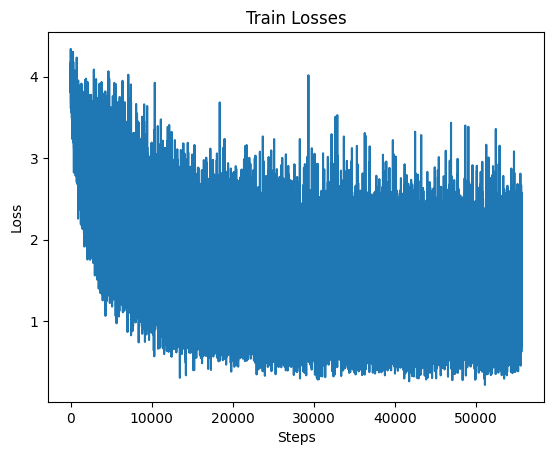

In [ ]:
import matplotlib.pyplot as plt

# show train losses
plt.plot(losses_train)
plt.title("Train Losses")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

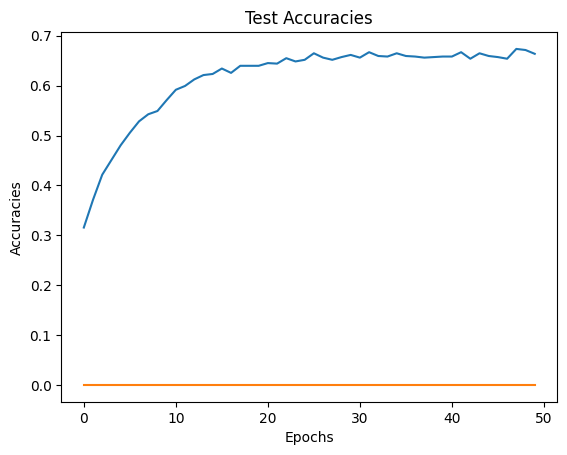

In [ ]:
# show seen vs unseen test accuracies
plt.plot(accs_seen, label="Seen Accuracy")
plt.plot(accs_unseen, label="Unseen Accuracy")
plt.title("Test Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.show()

## EVAL

In [ ]:
model = AudioMAEClassifier(
    chkpt_dir="D:/Models/AudioMAE/pretrained.pth",
    use_hidden="first",
    finetune=False
)

model.load("D:/Models/AudioMAE/finetuned.pth")

model.to("cuda")

TRAIN_PATH = "D:/DATA/UCF101-Spectrograms/fbank-audiomae/train/"
TEST_SEEN_PATH = "D:/DATA/UCF101-Spectrograms/fbank-audiomae/test_seen/"
TEST_UNSEEN_PATH = "D:/DATA/UCF101-Spectrograms/fbank-audiomae/test_unseen/"

train_loader = FileDataLoader(
    root=TRAIN_PATH,
    batch_size=4,
    train=True
)

test_seen_loader = FileDataLoader(
    root=TEST_SEEN_PATH,
    batch_size=1,
    train=False
)

test_unseen_loader = FileDataLoader(
    root=TEST_UNSEEN_PATH,
    batch_size=1,
    train=False
)

In [ ]:
all_classes = [
    'ApplyEyeMakeup',
    'ApplyLipstick',
    'Archery',
    'BabyCrawling',
    'BalanceBeam',
    'BandMarching',
    'BasketballDunk',
    'BlowDryHair',
    'BlowingCandles',
    'BodyWeightSquats',
    'Bowling',
    'BoxingPunchingBag',
    'BoxingSpeedBag',
    'BrushingTeeth',
    'CliffDiving',
    'CricketBowling',
    'CricketShot',
    'CuttingInKitchen',
    'FieldHockeyPenalty',
    'FloorGymnastics',
    'FrisbeeCatch',
    'FrontCrawl',
    'Haircut',
    'HammerThrow',
    'Hammering',
    'HandStandPushups',
    'HandstandWalking',
    'HeadMassage',
    'IceDancing',
    'Knitting',
    'LongJump',
    'MoppingFloor',
    'ParallelBars',
    'PlayingCello',
    'PlayingDaf',
    'PlayingDhol',
    'PlayingFlute',
    'PlayingSitar',
    'Rafting',
    'ShavingBeard',
    'Shotput',
    'SkyDiving',
    'SoccerPenalty',
    'StillRings',
    'SumoWrestling',
    'Surfing',
    'TableTennisShot',
    'Typing',
    'UnevenBars',
    'WallPushups',
    'WritingOnBoard'
]

seen_classes = []
for _, labels in test_seen_loader:
    seen_classes.extend(labels.numpy().tolist())

seen_classes = set(seen_classes)
print(len(seen_classes))

unseen_classes = []
for _, labels in test_unseen_loader:
    unseen_classes.extend(labels.numpy().tolist())

unseen_classes = set(unseen_classes)
print(len(unseen_classes))

assert(len(set.union(seen_classes, unseen_classes)) == 51)

seen_class_names = [all_classes[i] for i in seen_classes]
unseen_class_names = [all_classes[i] for i in unseen_classes]

42
9


In [ ]:
def inference(model, device, test_loader):

    model.eval()
    total_features = []
    total_preds = []
    total_labels = []
    total_losses = []
    total_confidence = []
    with torch.no_grad():
        for audio, label in tqdm(test_loader):
            label = label.type(torch.LongTensor)            
            audio, label = audio.to(device), label.to(device)
            output, feat = model(audio)
            pred = output.argmax(dim=1, keepdim=True)
            confidence = torch.nn.functional.softmax(output,dim=1).max(dim=1, keepdim=True)[0]
            loss = nn.CrossEntropyLoss(reduction='none')(output, label)

            total_features.append(feat)
            total_preds.append(pred)
            total_losses.append(loss)
            total_labels.append(label)
            total_confidence.append(confidence)
            

    total_features = torch.cat(total_features, dim=0).cpu().detach().numpy()
    total_preds = torch.cat(total_preds, dim=0).cpu().detach().numpy()
    total_losses = torch.cat(total_losses, dim=0).cpu().detach().numpy()
    total_labels = torch.cat(total_labels, dim=0).cpu().detach().numpy()
    total_confidence = torch.cat(total_confidence, dim=0).cpu().detach().numpy()

    return total_features, total_preds, total_losses, total_labels, total_confidence

In [ ]:
seen_total_feats, seen_total_preds, seen_total_losses, seen_total_labels, seen_total_confidence = inference(model, "cuda", test_seen_loader)
unseen_total_feats, unseen_total_preds, unseen_total_losses, unseen_total_labels, unseen_total_confidence = inference(model, "cuda", test_unseen_loader)

 31%|███       | 315/1018 [00:22<00:50, 14.01it/s]


KeyboardInterrupt: 

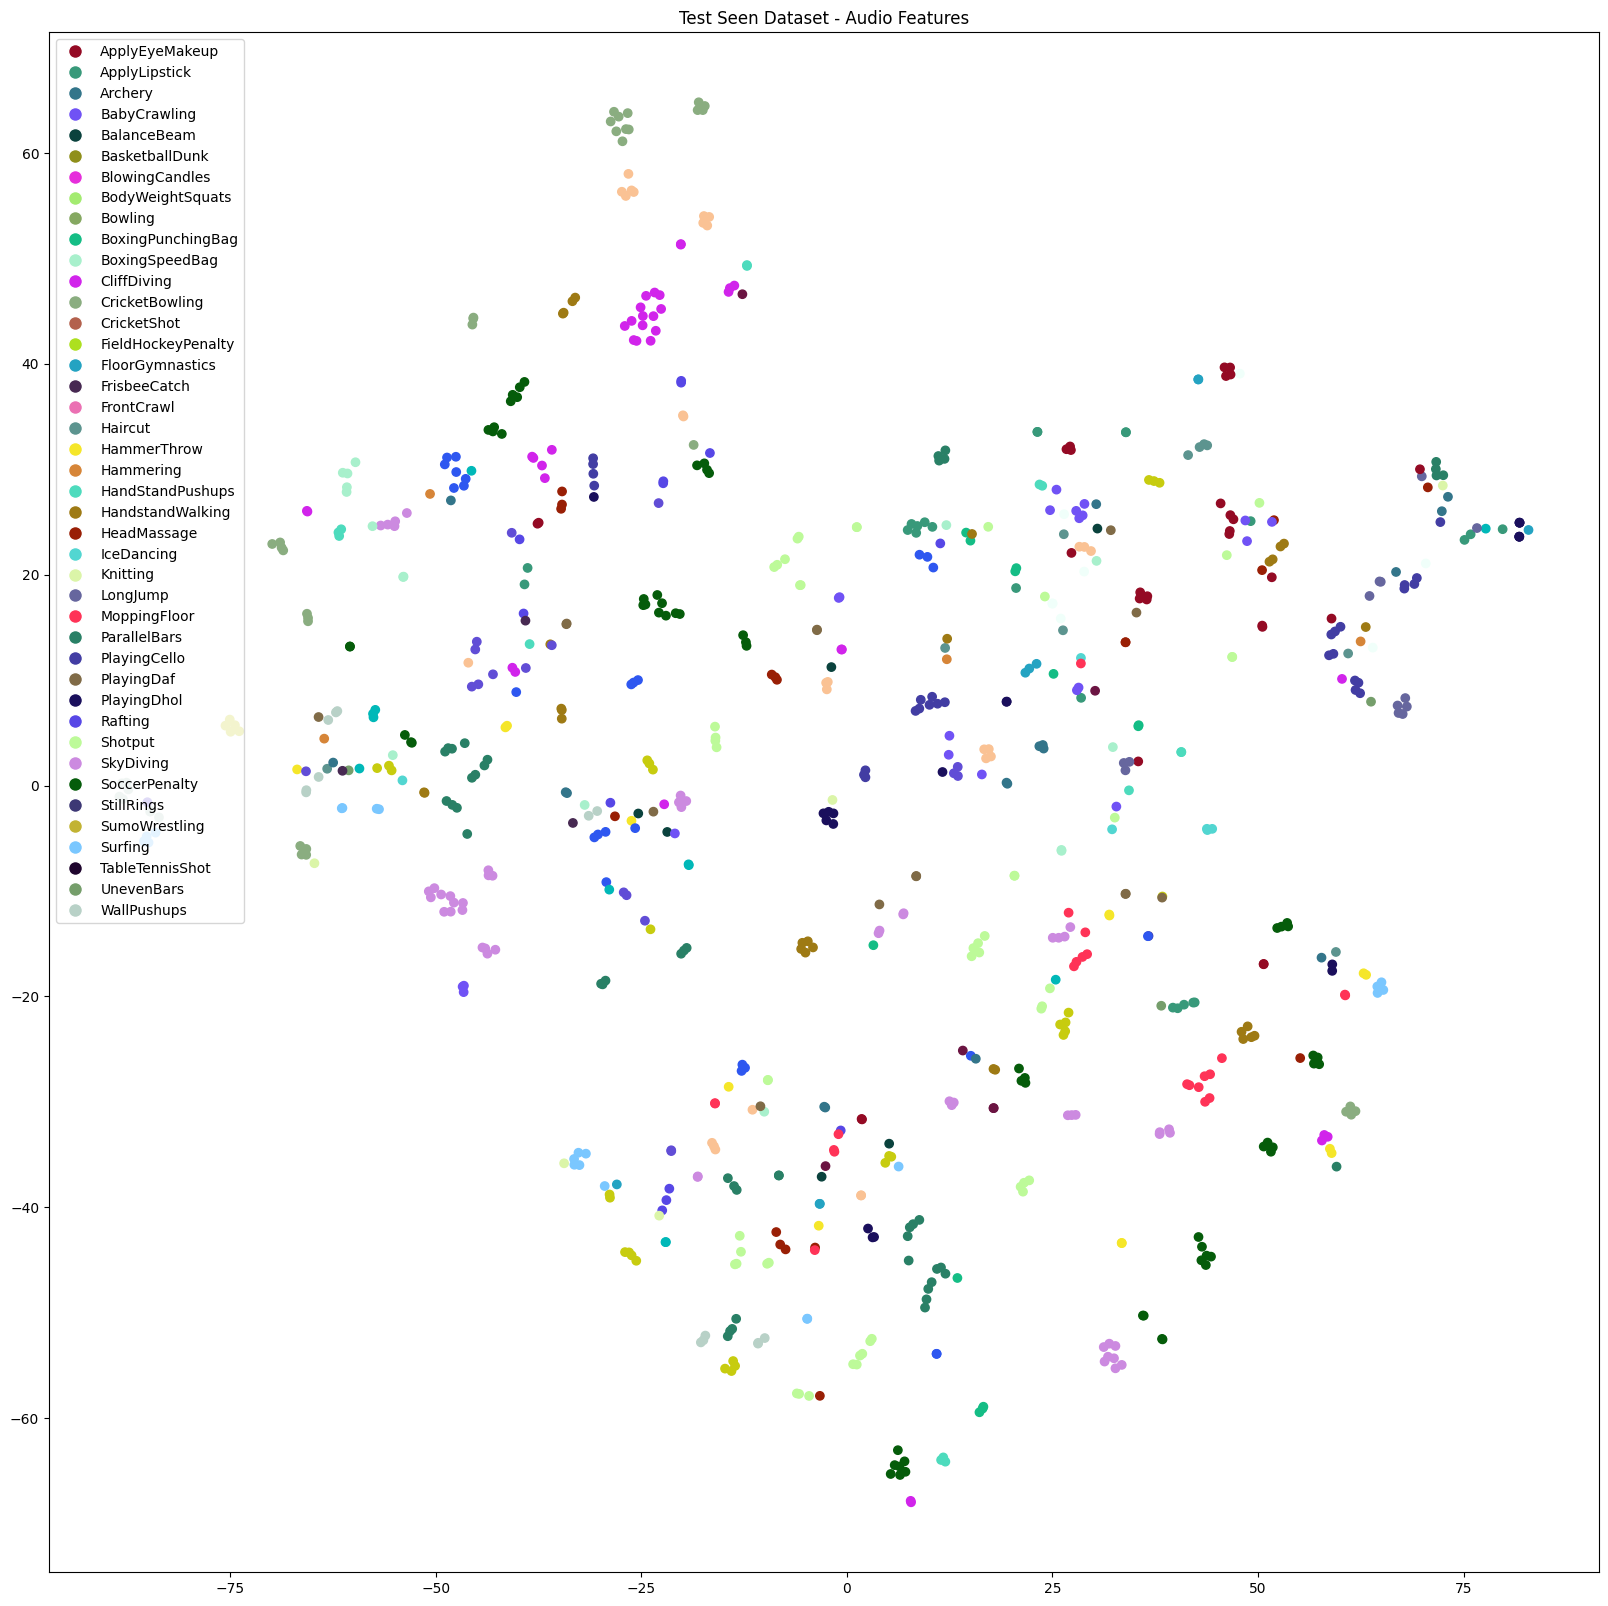

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D



def tsne(total_labels, total_features, classes, title):

    # tsne color
    r, g, b = np.linspace(0, 1, 51), np.linspace(0, 1, 51), np.linspace(0, 1, 51)
    np.random.seed(0)
    np.random.shuffle(r)
    np.random.shuffle(g)
    np.random.shuffle(b)
    r = r.reshape((-1, 1))
    g = g.reshape((-1, 1))
    b = b.reshape((-1, 1))
    class_colors = np.concatenate((r, g, b), axis=1)
    colors = class_colors[total_labels]

    # compute 2d tsne
    tsne = TSNE(perplexity=8, random_state=0) # perplexity=8
    X_2d = tsne.fit_transform(total_features)

    # plot
    plt.figure(figsize=(20, 20))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors)

    # legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=classes[i], markersize=10,
                          markerfacecolor=class_colors[i]) for i in range(len(classes))]
    plt.title(title)
    plt.legend(handles=legend_elements, loc='upper left')

    plt.show()
            
    return

tsne(seen_total_labels, seen_total_feats, seen_class_names, title='Test Seen Dataset - Audio Features')

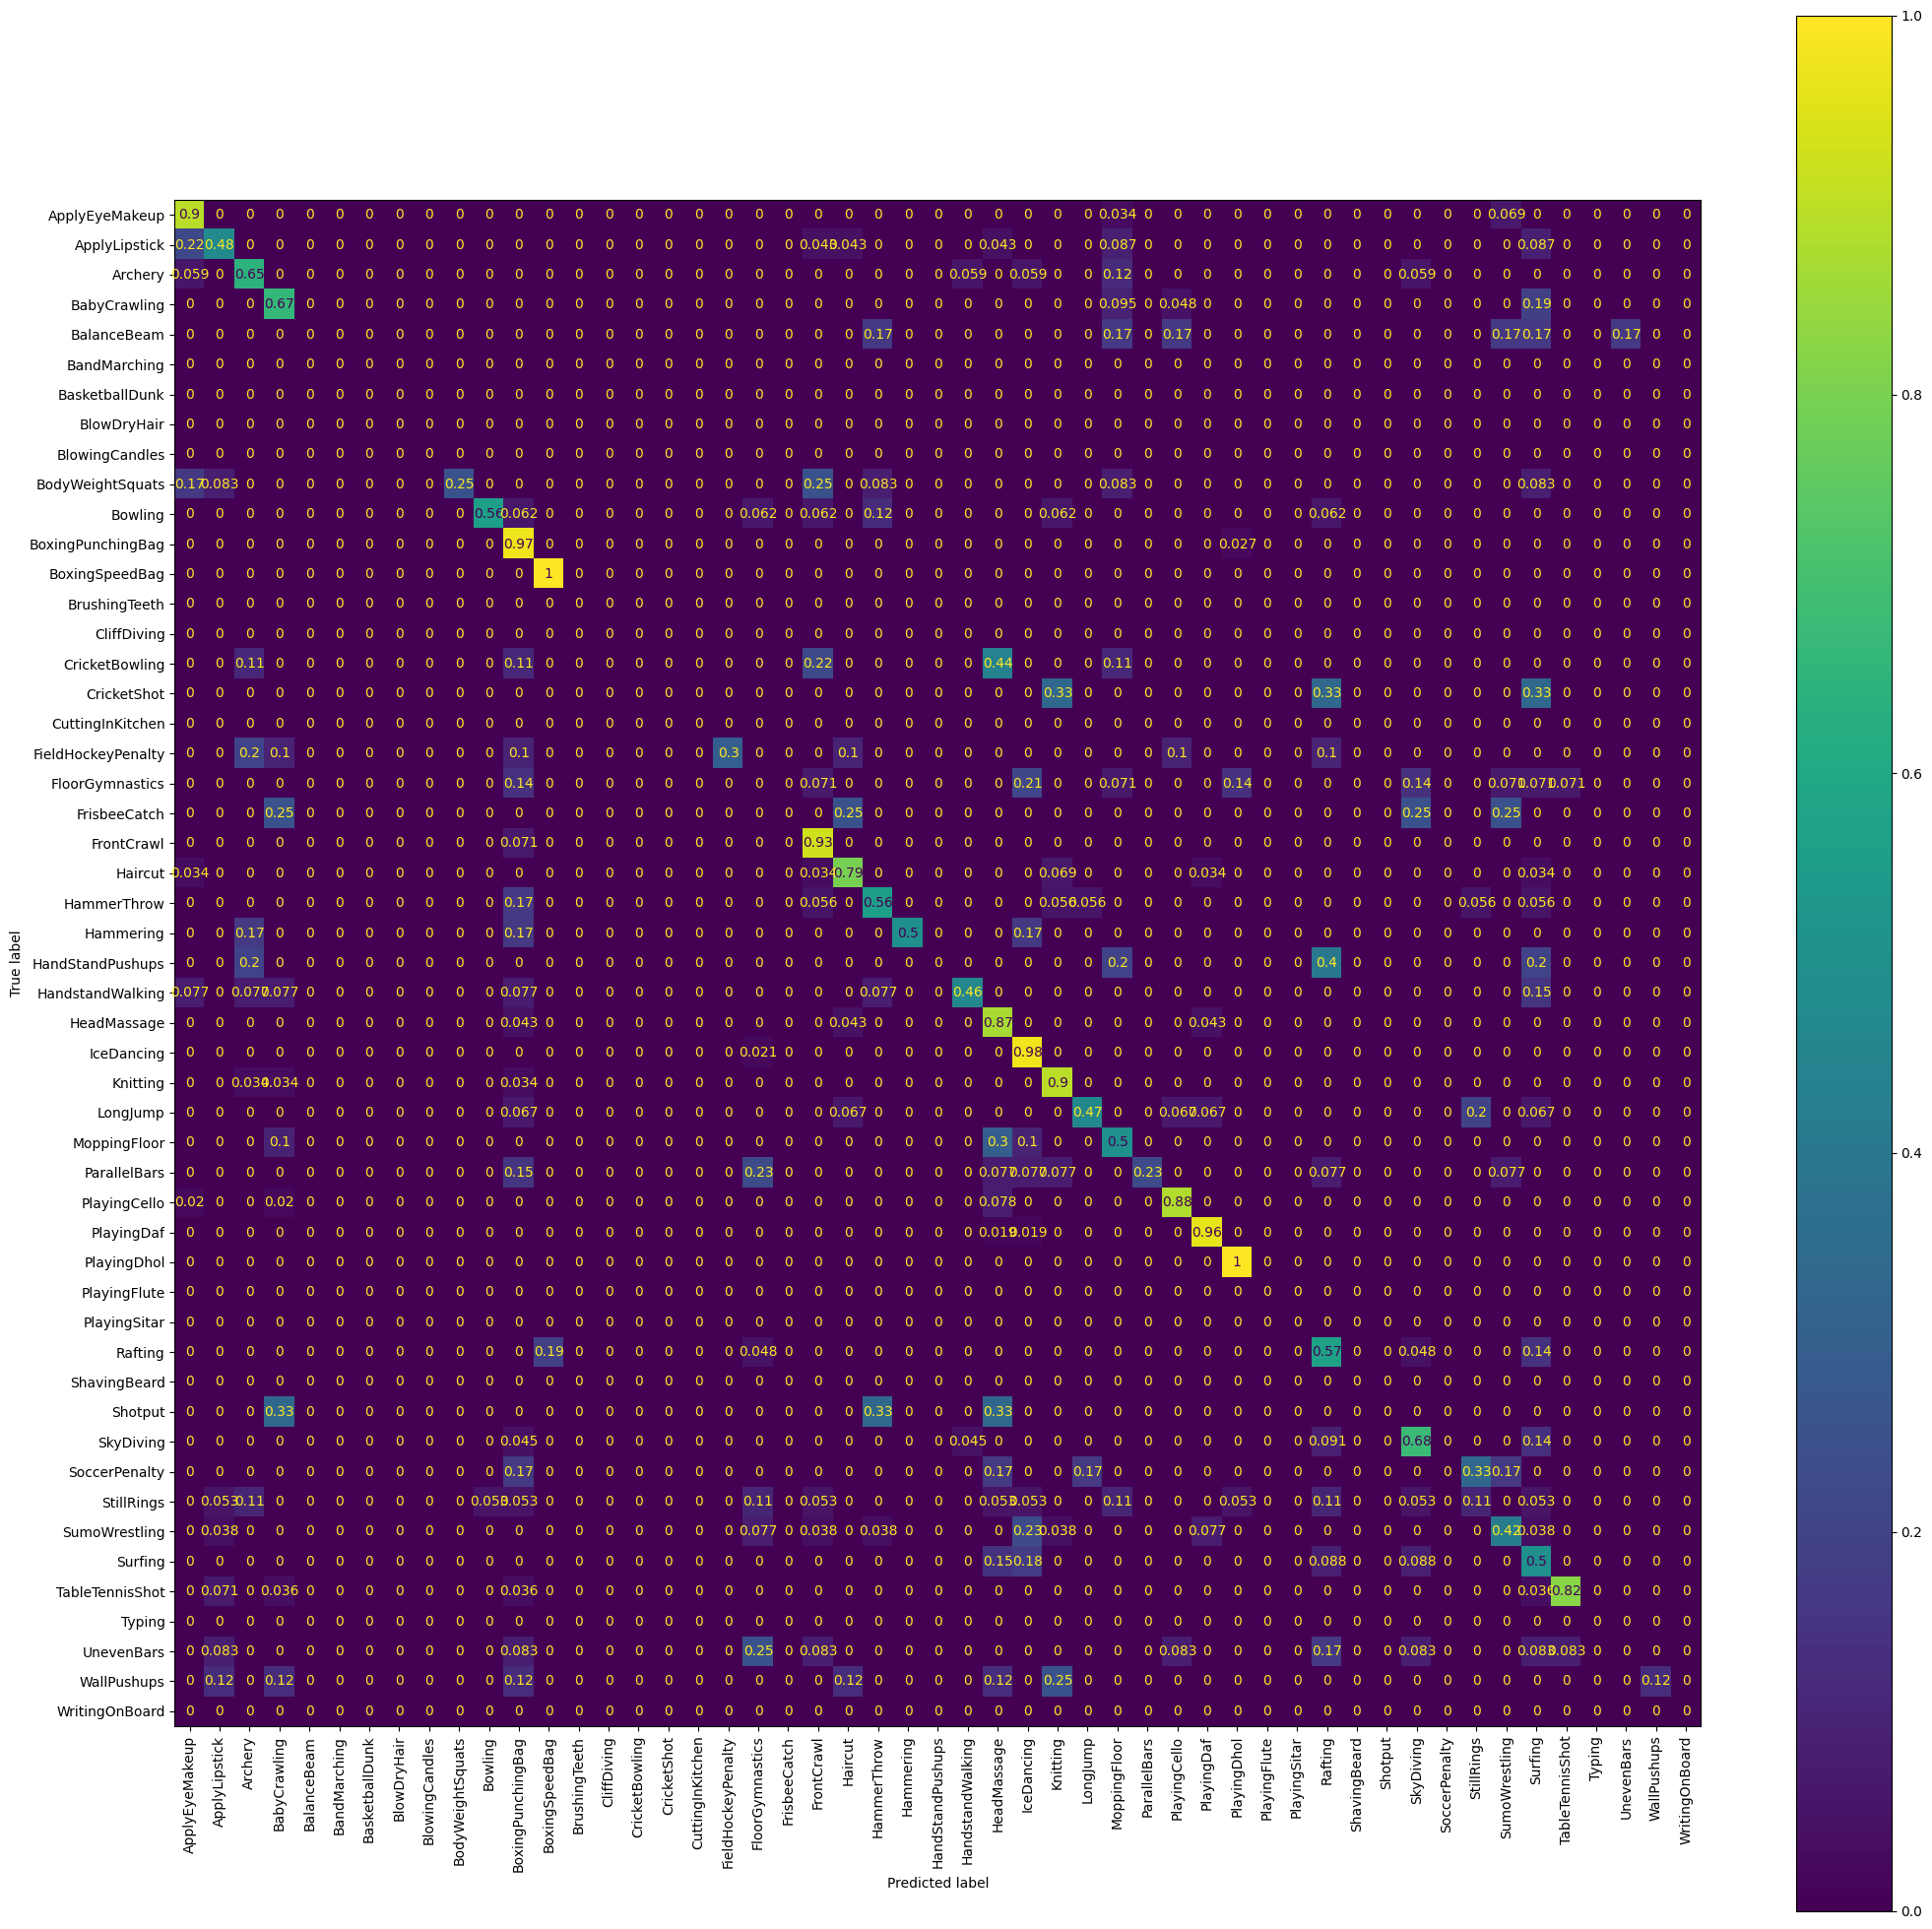

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, num_labels, labels, fsize=(15, 15)):
    fig, ax = plt.subplots(figsize=fsize)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, labels=np.arange(num_labels), display_labels=labels, xticks_rotation="vertical", normalize='true')
    return

plot_confusion_matrix(seen_total_labels, seen_total_preds, 51, all_classes, fsize=(25, 25))

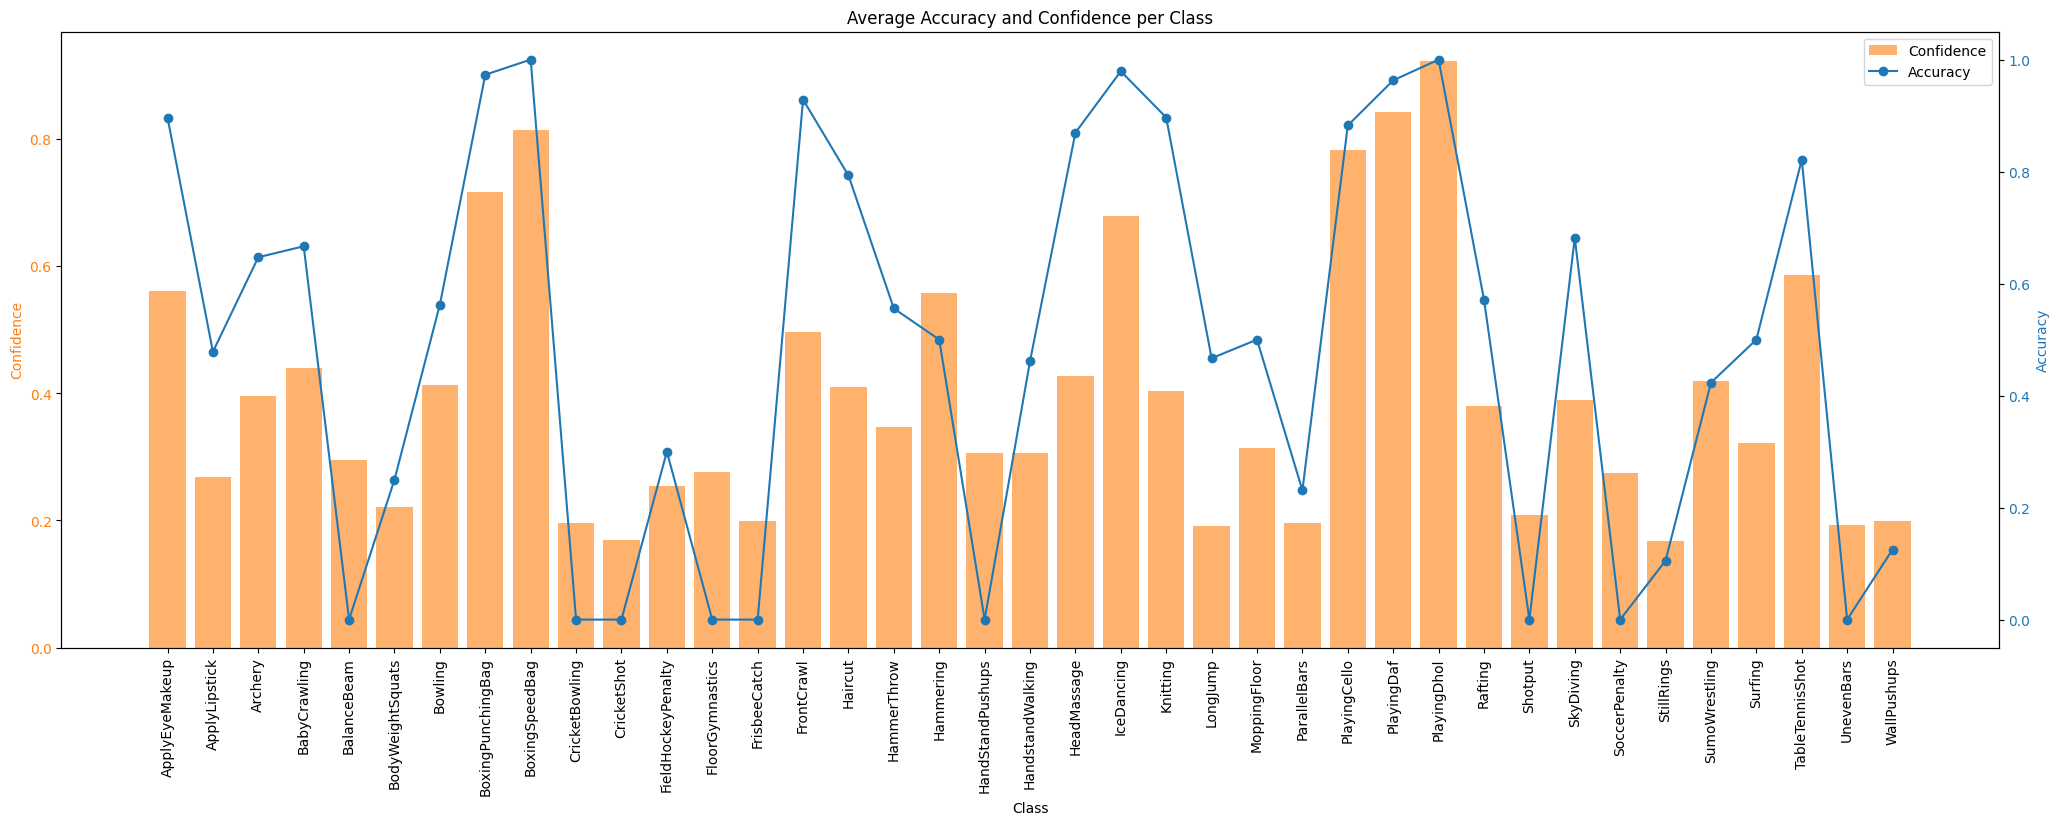

In [ ]:
import collections

def loss_acc_per_class(total_losses, total_preds, total_labels, classes):
    # loss
    loss_per_class = {class_id: [] for class_id in range(len(classes))}
    for i, label in enumerate(total_labels):
        loss_per_class[label].append(total_losses[i])
    for k, v in loss_per_class.items():
        loss_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in loss_per_class.keys()]
    yloss = list(loss_per_class.values())

    # accuracy
    acc_per_class = {class_id: [] for class_id in range(len(classes))}
    total_preds = total_preds.flatten()

    for i, label in enumerate(total_labels):
        if label == total_preds[i]: acc = 1
        else: acc = 0
        acc_per_class[label].append(acc)

    for k, v in acc_per_class.items():
        acc_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in acc_per_class.keys()]
    yacc = list(acc_per_class.values())

    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(25, 8))

    # exclude class with 0 data
    x = [x[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    filt_yloss = [yloss[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    yacc =  [yacc[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]

    # Plot loss
    color = 'tab:orange'
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Confidence', color=color)
    ax1.bar(x, filt_yloss, color=color, alpha=0.6, label='Confidence')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Create second axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(x, yacc, color=color, marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Title and legend
    plt.title('Average Accuracy and Confidence per Class')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show plot
    plt.show()
    
    return

loss_acc_per_class(seen_total_confidence, seen_total_preds, seen_total_labels, all_classes)